# Classification of Native and Non-Native English Accents

In [2]:
import os
import IPython.display as ipd
import librosa
# import librosa.display
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchaudio.transforms as TaudioT
import numpy as np
import random
import pandas as pd

## Data Exploration

The different accents we have in our dataset

In [3]:
data_path = './accentdb_extended_combined/data/'
accents = [accent for accent in os.listdir(data_path) if accent[0] != '.']
print(accents)
print('count: ', len(accents))

['indian', 'malayalam', 'australian', 'odiya', 'welsh', 'telugu', 'bangla', 'british', 'american']
count:  9


The number of audio samples we have for each accents

In [4]:
for accent in accents:
    files = [file for file in os.listdir(data_path + accent + '/') if file[0] != '.']
    print((accent, len(files)))

('indian', 1484)
('malayalam', 2393)
('australian', 1484)
('odiya', 747)
('welsh', 742)
('telugu', 1515)
('bangla', 1528)
('british', 1484)
('american', 5936)


Let's take a sample wave file and listen to what the recording sounds like.

In [5]:
wave_file = "./accentdb_extended_combined/data/indian/indian_s01_008.wav"
# Audio is part of IPython's disply module providing audio controls
ipd.Audio(filename=wave_file)

Let's see a pressure vs time graph of the wave file

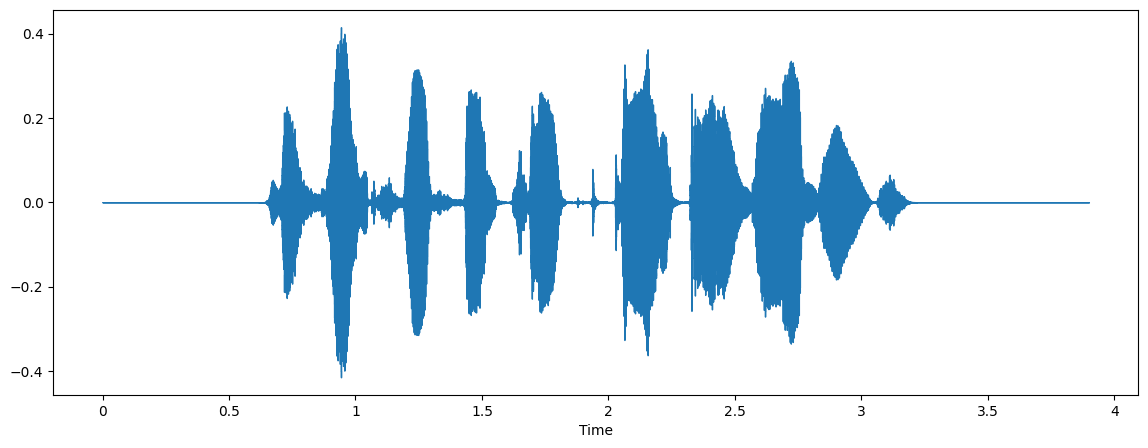

In [6]:
# librosa is a python package for music and audio analysis
# load converts a wave file to audio time series numpy array
# return:
# x -> numpy ndarray; audio time series multi channel supported
# sr -> scalar value; sample rate
x, sr = librosa.load(wave_file)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
plt.show()

Mel-frequency cepstral coefficients (MFCC) is known in the audio signal analisys field to be the best representation for human speech audio signals.  Let's convert this wave file into an MFCC frame, and see what it looks like.

(30, 168)


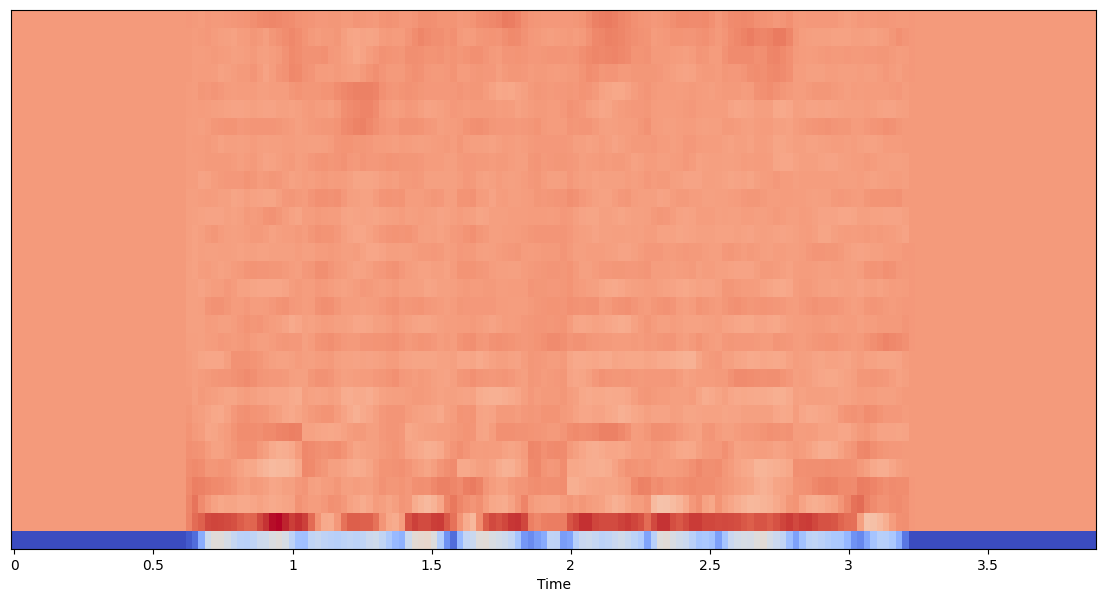

In [7]:
# librosa's feature extraction module mfcc converter
# returns a numpy array of mfcc sequence
mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=30)
print(mfccs.shape)

plt.figure(figsize=(14, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

Exploring meta data

indian
AudioMetaData(sample_rate=22050, num_frames=81585, num_channels=1, bits_per_sample=16, encoding=PCM_S)


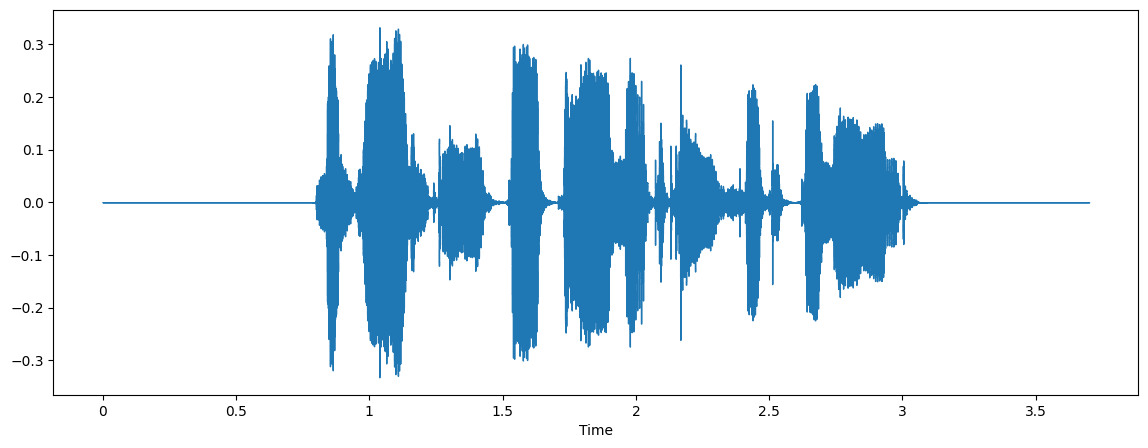

malayalam
AudioMetaData(sample_rate=48000, num_frames=249600, num_channels=2, bits_per_sample=16, encoding=PCM_S)


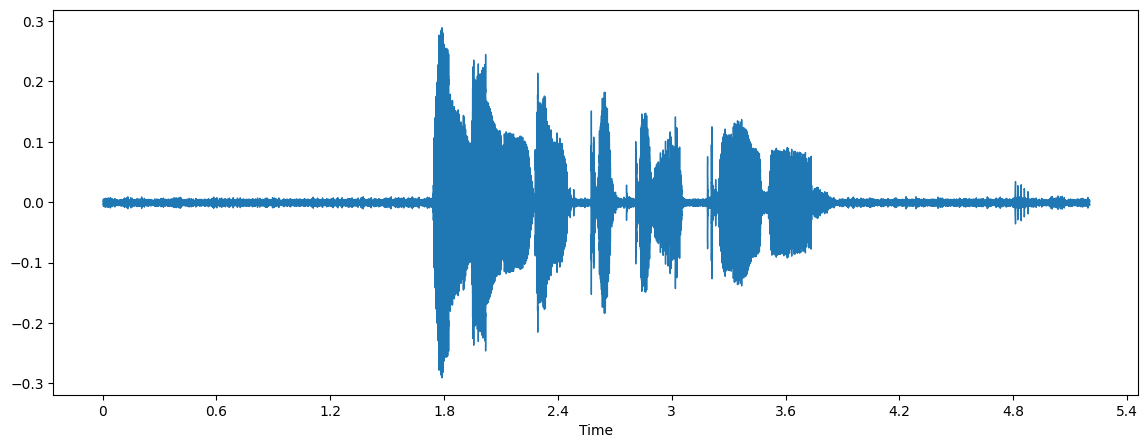

australian
AudioMetaData(sample_rate=22050, num_frames=77175, num_channels=1, bits_per_sample=16, encoding=PCM_S)


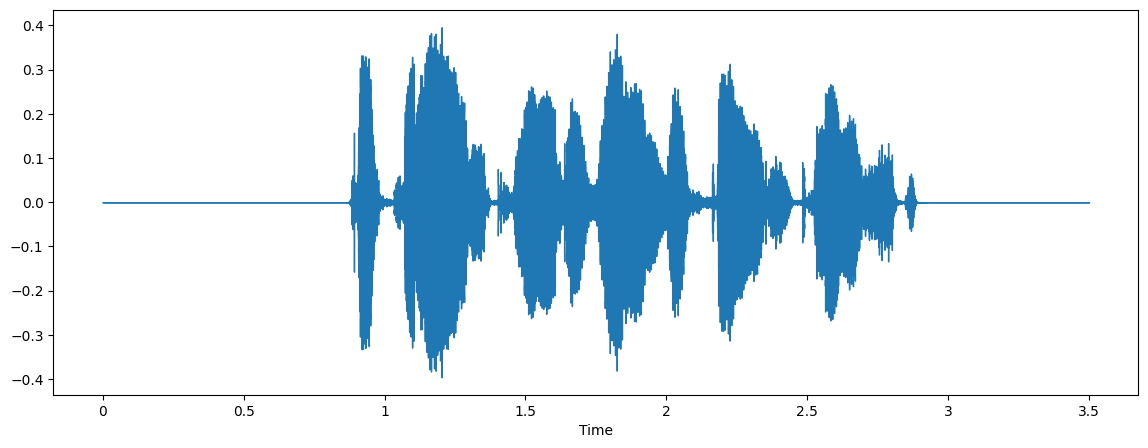

odiya
AudioMetaData(sample_rate=48000, num_frames=220800, num_channels=2, bits_per_sample=16, encoding=PCM_S)


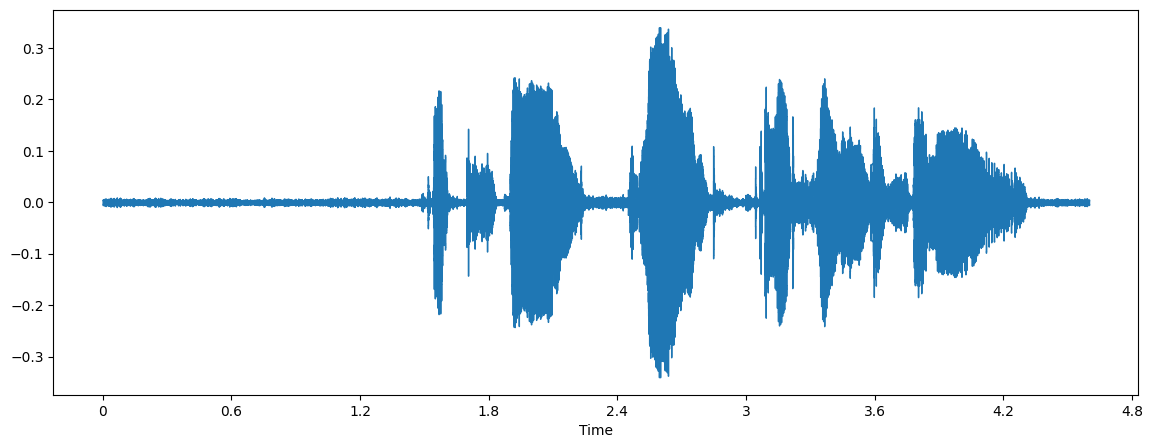

welsh
AudioMetaData(sample_rate=22050, num_frames=74970, num_channels=1, bits_per_sample=16, encoding=PCM_S)


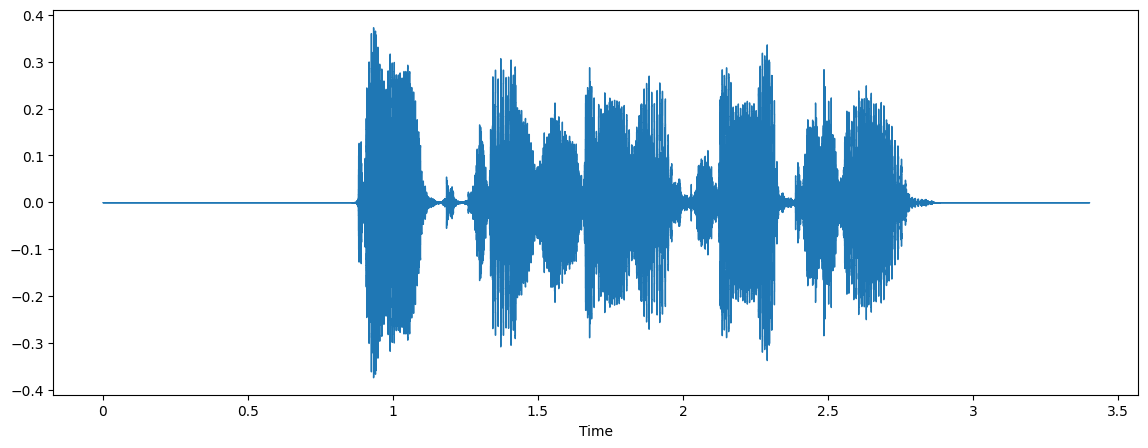

telugu
AudioMetaData(sample_rate=48000, num_frames=249600, num_channels=2, bits_per_sample=16, encoding=PCM_S)


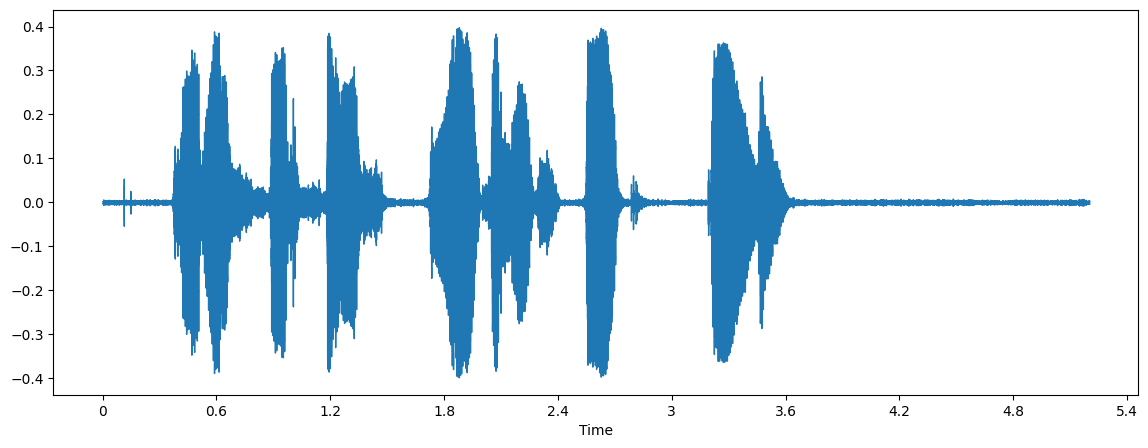

bangla
AudioMetaData(sample_rate=48000, num_frames=249600, num_channels=2, bits_per_sample=16, encoding=PCM_S)


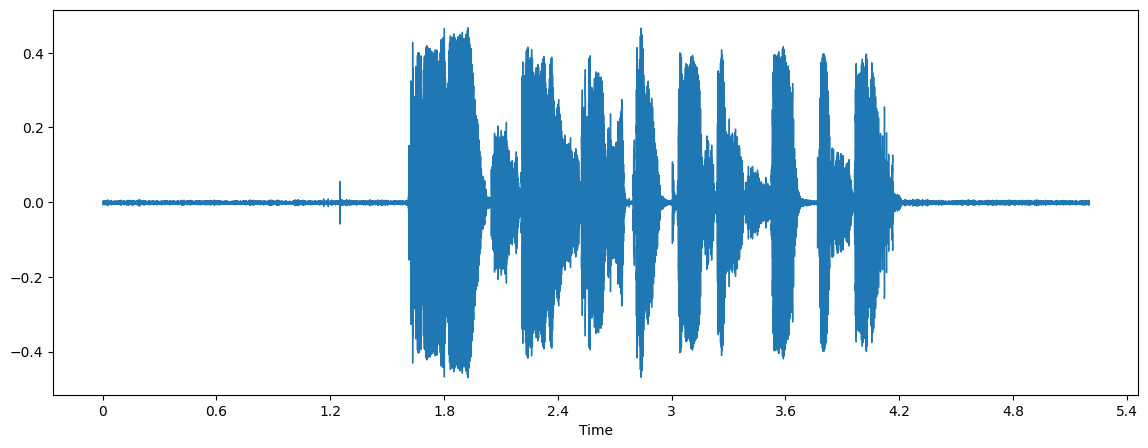

british
AudioMetaData(sample_rate=22050, num_frames=81585, num_channels=1, bits_per_sample=16, encoding=PCM_S)


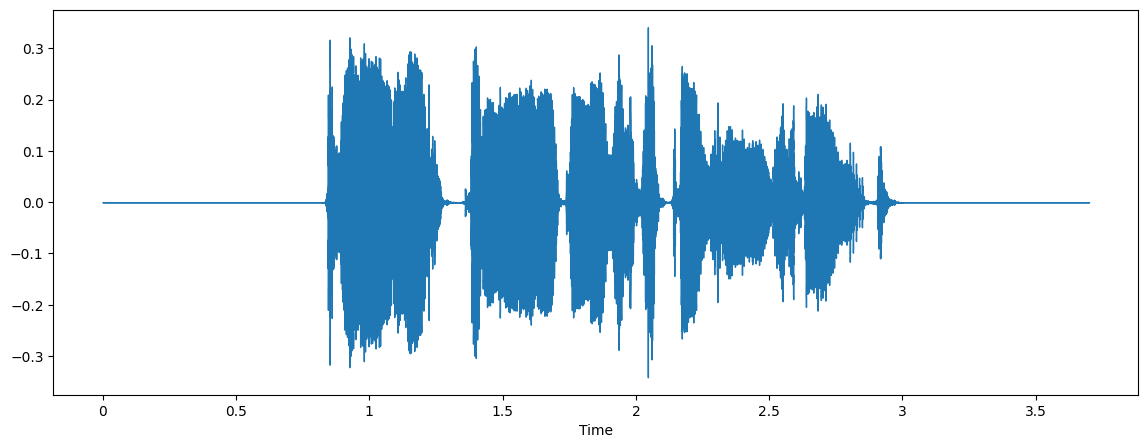

american
AudioMetaData(sample_rate=22050, num_frames=68355, num_channels=1, bits_per_sample=16, encoding=PCM_S)


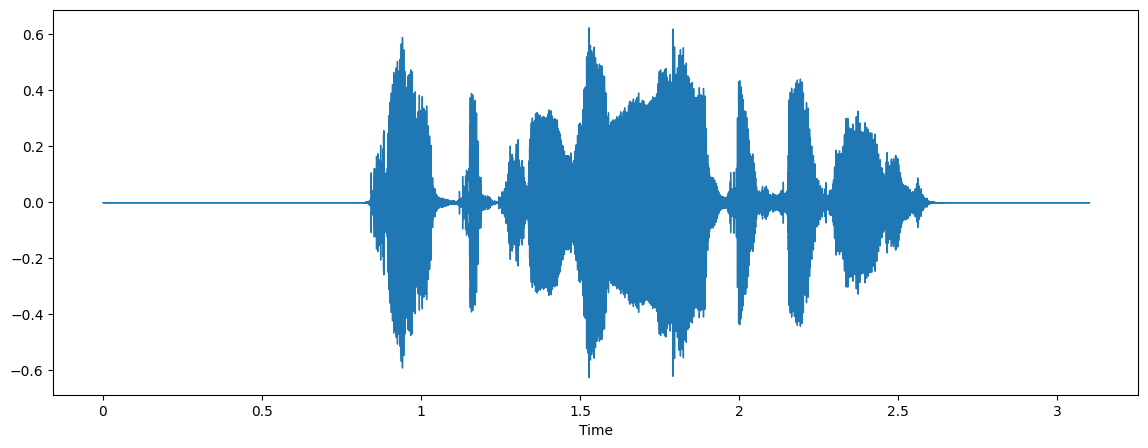

In [8]:
for accent in accents:
    path = data_path + accent + '/'
    print(accent)
    directory = [file for file in os.listdir(path) if file[0] != '.']
    for file in directory:
        file_path = path + file
        print(torchaudio.info(file_path))
        x, sr = librosa.load(file_path)
        plt.figure(figsize=(14, 5))
        librosa.display.waveshow(x, sr=sr)
        plt.show()
        break

We see difference in sample rate (22050 vs 48000) and number of channels (mono vs stereo) which translates into difference in dimensions of resulting MFCC representation which is an issue for our modeling process that we need to address.

In [9]:
# helper functions
def mono_to_stereo(signal):
    x, sr = signal
    if x.shape[0] == 2:
        return signal
    stereo = torch.cat([x, x])
    return stereo, sr

def resample(signal, new_sr=22050):
    x, sr = signal
    if sr == new_sr:
        return signal
    channel_1 = TaudioT.Resample(sr, new_sr)(x[:1, :])
    channel_2 = TaudioT.Resample(sr, new_sr)(x[1:, :])
    new_x = torch.cat([channel_1, channel_2])
    return new_x, new_sr

def limit_length(sig, ms=3000):
    x, sr = sig
    rows, audio_len = x.shape
    max_len = sr // 1000 * ms

    if audio_len > max_len:
        x = x[:, :max_len]
    elif audio_len < max_len:
        diff = max_len - audio_len
        append_start_len = random.randint(0, diff)
        append_stop_len = diff - append_start_len
        append_start = torch.zeros((rows, append_start_len))
        append_stop = torch.zeros((rows, append_stop_len))

        x = torch.cat((append_start, x, append_stop), 1)
    return x, sr

def mfcc(signal, n_mels=20):
    x, sr = signal
    melkwargs = {
        "n_fft": 512, "n_mels": n_mels, "hop_length": None, "mel_scale": "htk"
    }
    mfcc_transformer = TaudioT.MFCC(
        sample_rate = sr,
        n_mfcc = n_mels,
        melkwargs=melkwargs
    )
    mfcc_frames = mfcc_transformer(x)
    spec = TaudioT.AmplitudeToDB(top_db=80)(mfcc_frames)
    return spec


Let's convert one audio sample to see what we are dealing with

In [10]:
signal = torchaudio.load(wave_file)
signal = mono_to_stereo(signal)
signal = resample(signal)
signal = limit_length(signal)
mfcc_frame = mfcc(signal)

print(mfcc_frame.shape)

mfcc_frame

torch.Size([2, 20, 258])


tensor([[[-60.6520, -60.6520, -60.6520,  ..., -60.6520, -60.6520, -60.6520],
         [-52.3775, -52.3775, -52.3775,  ...,  17.6589,  17.0803,  15.8415],
         [-60.6520, -60.6520, -60.6520,  ...,   9.8607,  12.2282,  15.3684],
         ...,
         [-42.1795, -42.1795, -42.1795,  ...,  -3.7579,   5.5471,   3.9661],
         [-60.6520, -60.6520, -60.6520,  ...,  -2.3994, -60.6520,   2.3849],
         [-39.6610, -39.6610, -39.6610,  ..., -60.6520, -22.3273, -60.6520]],

        [[-60.6520, -60.6520, -60.6520,  ..., -60.6520, -60.6520, -60.6520],
         [-52.3775, -52.3775, -52.3775,  ...,  17.6589,  17.0803,  15.8415],
         [-60.6520, -60.6520, -60.6520,  ...,   9.8607,  12.2282,  15.3684],
         ...,
         [-42.1795, -42.1795, -42.1795,  ...,  -3.7579,   5.5471,   3.9661],
         [-60.6520, -60.6520, -60.6520,  ...,  -2.3994, -60.6520,   2.3849],
         [-39.6610, -39.6610, -39.6610,  ..., -60.6520, -22.3273, -60.6520]]])

In [11]:
def convert(wave, n_mels=20):
    signal = torchaudio.load(wave)
    signal = mono_to_stereo(signal)
    signal = resample(signal)
    signal = limit_length(signal)
    spec = mfcc(signal, n_mels=n_mels)
    return spec

Let's convert the rest of the audio samples.  Since "welsh" has the lowest number of samples at 742, to keep balance in our dataset, we will convert 742 samples from each accent, and take the full 5936 from "american" for a perfectly balanced dataset for a binary classification predicting "american" vs "non-american" accents (8 x 742 = 5936)

In [12]:
X_full = []
y_full = []

for accent in accents:
    count = 742 if accent != 'american' else 5936
    target_label = 0 if accent != 'american' else 1
    for file in os.listdir(data_path + accent + '/'):
        if file[0] != '.':
            wave_file_path = data_path + accent + '/' + file
            X_full.append(convert(wave_file_path))
            y_full.append(target_label)
            count -= 1
        if count == 0: break


In [13]:
X_full = np.stack(X_full)
y_full = np.array(y_full)

In [14]:
X_full.shape

(11872, 2, 20, 258)

In [15]:
y_full.shape

(11872,)

Save 4D numpy array and target vector to disk

In [16]:
np.save('american-v-all-4D.npy', X_full)

In [17]:
np.save('american-v-all-target.npy', y_full)

Scale 4D data to [0, 1]

In [18]:
X_min = X_full.min(axis=(0, 1), keepdims=True)
X_max = X_full.max(axis=(0, 1), keepdims=True)

X_full_norm = (X_full - X_min)/(X_max - X_min)

In [19]:
print('x_full_norm:\n ', X_full_norm[0][0])

x_full_norm:
  [[0.03269858 0.03267265 0.03264977 ... 0.03056916 0.03057555 0.03055019]
 [0.20172362 0.19994539 0.1996589  ... 0.98643553 0.986415   0.98188984]
 [0.03062229 0.03076158 0.03078325 ... 0.9633511  0.9779411  0.9556566 ]
 ...
 [0.28613976 0.292771   0.29162768 ... 0.8525724  0.8462519  0.02101059]
 [0.03432792 0.03511953 0.03535734 ... 0.9273171  0.87334627 0.90538657]
 [0.32341334 0.3275945  0.32413495 ... 0.02078276 0.91191095 0.9519666 ]]


Let's convert another set with a higher n_mel value to have a more detailed representation of each wave file and a higher dimensional data to work with for more powerful machine learning algorithms.  In addition we will attempt multiclass classification models predicting each accents available in our dataset.

In [20]:
X_hd_full = []
y_hd_full = []

for accent in accents:
    count = 742
    for file in os.listdir(data_path + accent + '/'):
        if file[0] != '.':
            wave_file_path = data_path + accent + '/' + file
            X_hd_full.append(convert(wave_file_path, n_mels=64))
            y_hd_full.append(accents.index(accent))
            count -= 1
        if count == 0: break


In [21]:
X_hd_full = np.stack(X_hd_full)
y_hd_full = np.stack(y_hd_full)

In [22]:
print('X_hd_full: ', X_hd_full.shape)
print('y_hd_full: ', y_hd_full.shape)

X_hd_full:  (6678, 2, 64, 258)
y_hd_full:  (6678,)


Let's make sure our target values reflect each class within our y vector

In [23]:
index = 0
for i in range(9):
    index += i + 741 if i == 0 else 742
    print(f'For {accents[i]} the target value is {y_hd_full[index]}')

For indian the target value is 0
For malayalam the target value is 1
For australian the target value is 2
For odiya the target value is 3
For welsh the target value is 4
For telugu the target value is 5
For bangla the target value is 6
For british the target value is 7
For american the target value is 8


Save 4D high dimension multiclass dataset onto disk

In [24]:
np.save('multiclass-4D-hd.npy', X_hd_full)

In [25]:
np.save('multiclass-4D-hd-target.npy', y_hd_full)

Scale 4D high dimensional multiclass dataset to [0, 1]

In [26]:
X_hd_min = X_hd_full.min(axis=(0, 1), keepdims=True)
X_hd_max = X_hd_full.max(axis=(0, 1), keepdims=True)

X_hd_full_norm = (X_hd_full - X_hd_min)/(X_hd_max - X_hd_min)

In [27]:
print(X_hd_full_norm)

[[[[0.47831094 0.47831094 0.47831094 ... 0.02559392 0.02404624
    0.02418319]
   [0.01918079 0.01913963 0.01912309 ... 0.98475254 0.9857897
    0.9787905 ]
   [0.01992386 0.01989176 0.01991858 ... 0.9664456  0.9809064
    0.96010405]
   ...
   [0.02459069 0.0248081  0.02355036 ... 0.81785756 0.02437684
    0.90581524]
   [0.32892346 0.335156   0.3320497  ... 0.8438036  0.93301946
    0.0215213 ]
   [0.31000295 0.31400564 0.3159429  ... 0.93861854 0.92364275
    0.02315252]]

  [[0.47831094 0.47831094 0.47831094 ... 0.02559392 0.02404624
    0.02418319]
   [0.01918079 0.01913963 0.01912309 ... 0.98475254 0.9857897
    0.9787905 ]
   [0.01992386 0.01989176 0.01991858 ... 0.9664456  0.9809064
    0.96010405]
   ...
   [0.02459069 0.0248081  0.02355036 ... 0.81785756 0.02437684
    0.90581524]
   [0.32892346 0.335156   0.3320497  ... 0.8438036  0.93301946
    0.0215213 ]
   [0.31000295 0.31400564 0.3159429  ... 0.93861854 0.92364275
    0.02315252]]]


 [[[0.50025547 0.50025547 0.50025547

Restructuring our dataset from 4d to 2d

In [28]:
data = []
for audio in X_full:
    data.append(audio[0].flatten())

df = pd.DataFrame(data)
data = np.stack(data)

In [29]:
data.shape

(11872, 5160)

Save 2D array as csv

In [30]:
np.save('american-v-all-2D.npy', data)

### Train Test Split

In [31]:
from sklearn.model_selection import train_test_split

Splitting our 2D data for non neural net model fitting

In [32]:
X2d_train, X2d_test, y2d_train, y2d_test = train_test_split(data, y_full, test_size=0.15, random_state=42)

Splitting our 4D data for neural net model fitting

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_full_norm, y_full, test_size=0.15, random_state=42)

In [34]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (10091, 2, 20, 258)
y_train (10091,)
X_test (1781, 2, 20, 258)
y_test (1781,)


Splitting our 4D high dimensional data for more powerful neural networks

In [35]:
X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_hd_full_norm, y_hd_full, test_size=0.15, random_state=42)

In [36]:
print('X_hd_train', X_hd_train.shape)
print('y_hd_train', y_hd_train.shape)
print('X_hd_test', X_hd_test.shape)
print('y_hd_test', y_hd_test.shape)

X_hd_train (5676, 2, 64, 258)
y_hd_train (5676,)
X_hd_test (1002, 2, 64, 258)
y_hd_test (1002,)


### Dimensionality Reduction of 2D data

#### PCA

In [37]:
from sklearn.decomposition import PCA

Peform principal component analysis while retaining 95% variance over our data

In [38]:
pca = PCA(n_components=0.95)

#### Random Forest as Feature Selection

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [40]:
rf_feature_select = SelectFromModel(RandomForestClassifier(n_estimators=100, max_leaf_nodes=9, n_jobs=-1))

### Combining Both Techniques

In [41]:
from sklearn.pipeline import Pipeline

In [42]:
full_pipeline = Pipeline(
    [('pca', pca), 
     ('rf', rf_feature_select)]
)

X2d_reduced = full_pipeline.fit_transform(X2d_train, y2d_train)

In [43]:
X2d_reduced.shape

(10091, 372)

Performing random forest as feature selection after having completed principal component analysis brought down the dimension of our data from 5160 to 379.  We will keep this setting as we explore the different models available to us.

## Exploring Different Models

### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
lr_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('lr', LogisticRegression())
])

lr_model.fit(X2d_train, y2d_train)

/Users/s1akr/classes/Machine-Learning/en-accent-classifcation/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('lr', LogisticRegression())])

In [46]:
lr_score = lr_model.score(X2d_test, y2d_test)

In [47]:
print(lr_score)

0.9343065693430657


### K-nearest Neighbors (KNN) Classifer

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
knn_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])

knn_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

In [50]:
knn_score = knn_model.score(X2d_test, y2d_test)

In [51]:
print(knn_score)

0.9831555306007861


### Support Vector Machines (SVM) Classifier

In [52]:
from sklearn.svm import SVC

In [53]:
svm_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('svm', SVC())
])

svm_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('svm', SVC())])

In [54]:
svm_score = svm_model.score(X2d_test, y2d_test)

In [55]:
print(svm_score)

0.9842784952274003


### Decision Trees Classifier

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
tree_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('tree', DecisionTreeClassifier(max_leaf_nodes=50))
])

tree_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('tree', DecisionTreeClassifier(max_leaf_nodes=50))])

In [58]:
tree_score = tree_model.score(X2d_test, y2d_test)

In [59]:
print(tree_score)

0.9477821448624368


### Random Forests Classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
forest_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('tree', RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, n_jobs=-1))
])

forest_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('tree',
                 RandomForestClassifier(max_leaf_nodes=50, n_estimators=500,
                                        n_jobs=-1))])

In [62]:
forest_score = forest_model.score(X2d_test, y2d_test)

In [63]:
print(forest_score)

0.9348680516563729


### AdaBoost Classifier

In [64]:
from sklearn.ensemble import AdaBoostClassifier

In [65]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500, algorithm="SAMME.R", learning_rate=0.1
)

ada_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('ada', ada_clf)
])

ada_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('ada',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.1, n_estimators=500))])

In [66]:
ada_score = ada_model.score(X2d_test, y2d_test)

In [67]:
print(ada_score)

0.9500280741156654


### Gradient Boosting Classifer

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

In [69]:
gdbst = GradientBoostingClassifier(
    max_depth=2, n_estimators=500, learning_rate=0.1
)

gdbst_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('gd', gdbst)
])

gdbst_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('gd',
                 GradientBoostingClassifier(max_depth=2, n_estimators=500))])

In [70]:
gdbst_score = gdbst_model.score(X2d_test, y2d_test)

In [71]:
print(gdbst_score)

0.9713644020213363


## Artificial Neural Networks

### Perceptron

In [72]:
from sklearn.linear_model import Perceptron

In [73]:
per_model = Pipeline([
    ('pca', pca),
    ('rf', rf_feature_select),
    ('per', Perceptron(n_jobs=-1))
])

per_model.fit(X2d_train, y2d_train)

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('rf',
                 SelectFromModel(estimator=RandomForestClassifier(max_leaf_nodes=9,
                                                                  n_jobs=-1))),
                ('per', Perceptron(n_jobs=-1))])

In [74]:
per_result = per_model.score(X2d_test, y2d_test)

In [75]:
print(per_result)

0.9185850645704661


### Multilayer Perceptron (MLP) Binary Classification

In [109]:
import tensorflow as tf
from tensorflow import keras

In [78]:
mlp_model = keras.models.Sequential()
mlp_model.add(keras.layers.Flatten(input_shape=[2, 20, 258]))
mlp_model.add(keras.layers.Dense(300, activation="relu"))
mlp_model.add(keras.layers.Dense(100, activation="relu"))
mlp_model.add(keras.layers.Dense(1, activation="sigmoid"))

In [79]:
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10320)             0         
                                                                 
 dense_3 (Dense)             (None, 300)               3096300   
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,126,501
Trainable params: 3,126,501
Non-trainable params: 0
_________________________________________________________________


In [80]:
mlp_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
    metrics=["accuracy"]
)

In [81]:
mlp_history = mlp_model.fit(
    X_train, y_train, epochs=10,
    validation_split=0.1
)

Epoch 1/10
284/284 [==============================] - 6s 18ms/step - loss: 0.2031 - accuracy: 0.9099 - val_loss: 0.2221 - val_accuracy: 0.9030
Epoch 2/10
284/284 [==============================] - 5s 16ms/step - loss: 0.0503 - accuracy: 0.9811 - val_loss: 0.0471 - val_accuracy: 0.9812
Epoch 3/10
284/284 [==============================] - 4s 16ms/step - loss: 0.0219 - accuracy: 0.9916 - val_loss: 0.0812 - val_accuracy: 0.9812
Epoch 4/10
284/284 [==============================] - 5s 16ms/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0735 - val_accuracy: 0.9861
Epoch 5/10
284/284 [==============================] - 5s 16ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0659 - val_accuracy: 0.9851
Epoch 6/10
284/284 [==============================] - 5s 16ms/step - loss: 5.0424e-04 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9851
Epoch 7/10
284/284 [==============================] - 5s 17ms/step - loss: 2.5740e-04 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy

### Multilayer Preceptron (MLP) Multiclass Classification

In [90]:
mlp_model = keras.models.Sequential()
mlp_model.add(keras.layers.Flatten(input_shape=[2, 64, 258]))
mlp_model.add(keras.layers.Dense(200, activation="relu"))
mlp_model.add(keras.layers.Dense(100, activation="relu"))
mlp_model.add(keras.layers.Dense(100, activation="relu"))
mlp_model.add(keras.layers.Dense(100, activation="relu"))
mlp_model.add(keras.layers.Dense(9, activation="softmax"))

In [91]:
mlp_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 33024)             0         
                                                                 
 dense_14 (Dense)            (None, 200)               6605000   
                                                                 
 dense_15 (Dense)            (None, 100)               20100     
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                                 
 dense_17 (Dense)            (None, 100)               10100     
                                                                 
 dense_18 (Dense)            (None, 9)                 909       
                                                                 
Total params: 6,646,209
Trainable params: 6,646,209
No

In [92]:
mlp_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
    metrics=["accuracy"]
)

In [93]:
mlp_history = mlp_model.fit(
    X_hd_train, y_hd_train, epochs=10,
    validation_split=0.1
)

Epoch 1/10
160/160 [==============================] - 6s 33ms/step - loss: 1.0819 - accuracy: 0.5601 - val_loss: 0.9964 - val_accuracy: 0.6320
Epoch 2/10
160/160 [==============================] - 5s 31ms/step - loss: 0.5444 - accuracy: 0.7986 - val_loss: 0.4643 - val_accuracy: 0.8239
Epoch 3/10
160/160 [==============================] - 5s 31ms/step - loss: 0.2817 - accuracy: 0.9005 - val_loss: 0.3512 - val_accuracy: 0.8662
Epoch 4/10
160/160 [==============================] - 5s 31ms/step - loss: 0.0952 - accuracy: 0.9697 - val_loss: 0.1401 - val_accuracy: 0.9542
Epoch 5/10
160/160 [==============================] - 5s 31ms/step - loss: 0.0441 - accuracy: 0.9851 - val_loss: 0.2908 - val_accuracy: 0.9173
Epoch 6/10
160/160 [==============================] - 5s 31ms/step - loss: 0.0374 - accuracy: 0.9869 - val_loss: 0.1509 - val_accuracy: 0.9437
Epoch 7/10
160/160 [==============================] - 5s 31ms/step - loss: 0.0200 - accuracy: 0.9943 - val_loss: 0.1966 - val_accuracy: 0.9313

### Convolutional Neural Networks (CNN)

In [101]:
X_hd_train_reshaped = np.moveaxis(X_hd_train, 1, -1)
X_hd_test_reshaped = np.moveaxis(X_hd_test, 1, -1)

In [105]:
print("X_reshaped: ", X_hd_train_reshaped.shape)
print("X_train_reshaped: ", X_hd_test_reshaped.shape)

X_reshaped:  (5676, 64, 258, 2)
X_train_reshaped:  (1002, 64, 258, 2)


In [168]:
cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(128, 7, strides=2, activation="relu", padding="same", input_shape=[64, 258, 2]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, strides=2, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(9, activation="softmax"),
])

In [169]:
cnn_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 32, 129, 128)      12672     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 16, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 8, 32, 256)        295168    
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 4, 16, 256)       0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 16384)             0         
                                                                 
 dense_72 (Dense)            (None, 256)             

In [170]:
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam", 
    metrics=["accuracy"]
)

In [171]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb = keras.callbacks.ModelCheckpoint("cnn_multiclass.h5", save_best_only = True)
cnn_history = cnn_model.fit(
    X_hd_train_reshaped, y_hd_train, epochs=100,
    validation_split=0.1,
    callbacks=[checkpoint_cb, early_stopping_cb]
)
cnn_model = keras.models.load_model("cnn_multiclass.h5")

Epoch 1/100
160/160 [==============================] - 37s 223ms/step - loss: 1.7627 - accuracy: 0.2525 - val_loss: 1.2653 - val_accuracy: 0.5599
Epoch 2/100
160/160 [==============================] - 35s 220ms/step - loss: 0.9324 - accuracy: 0.6171 - val_loss: 0.3953 - val_accuracy: 0.8504
Epoch 3/100
160/160 [==============================] - 35s 217ms/step - loss: 0.4328 - accuracy: 0.8418 - val_loss: 0.1460 - val_accuracy: 0.9560
Epoch 4/100
160/160 [==============================] - 35s 221ms/step - loss: 0.2240 - accuracy: 0.9221 - val_loss: 0.0728 - val_accuracy: 0.9701
Epoch 5/100
160/160 [==============================] - 36s 226ms/step - loss: 0.1516 - accuracy: 0.9452 - val_loss: 0.0418 - val_accuracy: 0.9806
Epoch 6/100
160/160 [==============================] - 38s 238ms/step - loss: 0.1235 - accuracy: 0.9552 - val_loss: 0.0429 - val_accuracy: 0.9877
Epoch 7/100
160/160 [==============================] - 37s 234ms/step - loss: 0.1024 - accuracy: 0.9638 - val_loss: 0.0452 -

In [173]:
cnn_model.evaluate(X_hd_test_reshaped, y_hd_test)

32/32 [==============================] - 2s 66ms/step - loss: 0.0280 - accuracy: 0.9960


[0.02802869863808155, 0.9960079789161682]